In [10]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
from copy import deepcopy
import astropy
import gammapy
from astropy.table import Table, vstack
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, Background2D

gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.modeling.models import FoVBackgroundModel
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    FoVBackgroundMaker
    
)
from astropy.io import fits
from gammapy.estimators import *
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

CPU times: user 1.85 ms, sys: 1.16 ms, total: 3.01 ms
Wall time: 2.46 ms


In [11]:
source = "crab"

data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")


obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")



In [14]:
hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_NAME,HDU_NAME,FILE_DIR
int64,bytes6,bytes10,bytes54,bytes20,str33
64080,events,events,64080.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/crab
64080,gti,gti,64080.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/crab
64080,aeff,aeff_2d,64080.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/crab
64080,edisp,edisp_2d,64080.anasum.fits,ENERGY DISPERSION,/Users/cedrickperron/GAMMAPY/crab
64080,psf,psf_table,64080.anasum.fits,PSF,/Users/cedrickperron/GAMMAPY/crab
64080,bkg,bkg_2d,64080.anasum.fits,BKG,/Users/cedrickperron/GAMMAPY/crab
64081,events,events,64081.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/crab
64081,gti,gti,64081.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/crab
64081,aeff,aeff_2d,64081.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/crab


In [15]:
obs_table

OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST
,deg,deg,deg,deg,deg,s,s,,s,s,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20
64080,83.632614,22.514471,10.916365,79.08363,146.21132,1201.8021,1013.3333,0.84317815,242909540.0,242910740.0,4,"T1,T2,T3,T4"
64081,83.63405,21.514471,10.1721945,79.827805,172.61845,1201.8845,1014.0769,0.8437391,242910770.0,242911970.0,4,"T1,T2,T3,T4"
64082,84.17265,22.014256,10.088691,79.91131,197.49014,1201.8256,1005.3725,0.8365378,242912020.0,242913220.0,4,"T1,T2,T3,T4"
64083,83.09402,22.012922,12.755301,77.2447,222.99776,1201.8,1014.2434,0.84393686,242913250.0,242914450.0,4,"T1,T2,T3,T4"


In [16]:
data_store.obs_table
data_store.hdu_table = hdu_table

data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]



# Note NO HDU of HDU_TYPE = bkg. Write print(hdu_table) and you will see that there is no bkg.
observations = data_store.get_observations(obs_id)


In [17]:
"""
for i in range(len(observations)):
    
    observations[i].
"""


'\nfor i in range(len(observations)):\n    \n    observations[i].\n'

In [18]:

df=pd.read_csv('./GAMMAPY/exclusion mask.csv', sep=',',header=None)
ra_list = list(df[0])
dec_list = list(df[1])


region_list = []
for ra, dec in zip(ra_list, dec_list):
    region_list.append(make_region(f"icrs;circle({ra}, {dec}, 0.3)"))
    

exclusion_mask=[]
def exclusion_mask(geom, center_region):
    geom_image = geom
    exclusion_mask=Map.from_geom(geom)
    if center_region not in region_list:
        region_list.append(center_region)
    exclusion_mask.data=geom.region_mask(region_list, inside=False)
    return exclusion_mask

target_position = SkyCoord(ra="05h34m30.9s",dec="+22d00m44.5s", frame="icrs")
print(target_position)
# 0.089
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)
geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="5 deg", frame="galactic")
center_region = CircleSkyRegion(center=target_position, radius=0.30* u.deg)

exclusion_mask = exclusion_mask(geom, center_region)
exclusion_mask_int = exclusion_mask.copy()
exclusion_mask_int.data = exclusion_mask_int.data.astype(int)
exclusion_mask_int.write(f"/Users/cedrickperron/GAMMAPY/{source}/exclusion_mask_crab.fits", overwrite="True")

<SkyCoord (ICRS): (ra, dec) in deg
    (83.62875, 22.01236111)>


In [19]:
config = AnalysisConfig()
config.observations.obs_ids=list(obs_table["OBS_ID"])
config.observations.datastore = f"/Users/cedrickperron/GAMMAPY/{source}"

In [20]:
config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": "184.56 deg",
    "lat": "-5.79 deg",
    "frame": "galactic",
}
config.datasets.geom.wcs.fov = {"width": "5 deg", "height": "5 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"
config.datasets.geom.wcs.binsize_irf = "0.25 deg"
config.datasets.geom.selection.offset_max = 1.75 * u.deg
config.datasets.safe_mask.methods = ["aeff-default"]
config.datasets.safe_mask.parameters = {"aeff_percent":10, "offset_max":"1.75 deg"}
config.datasets.geom.axes.energy.min = "0.2 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 15
config.datasets.geom.axes.energy_true.min = "0.1 TeV"
config.datasets.geom.axes.energy_true.max = "17 TeV"
config.datasets.geom.axes.energy_true.nbins = 20
config.datasets.background.exclusion = (f"/Users/cedrickperron/GAMMAPY/{source}/exclusion_mask_crab.fits")
config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}

In [21]:
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: /Users/cedrickperron/GAMMAPY/crab
        obs_ids: [64080, 64081, 64082, 64083]
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: galactic, lon: 184.56 deg, lat: -5.79 deg}
                binsize: 0.02 deg
                fov: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.25 deg
            selection: {offset_max: 1.75 deg}
            axes:
                energy: {min: 0.2 TeV, max: 10.0 TeV, nbins: 15}
                energy_true: {min: 0.1 TeV, max: 17.0 TeV, nbins: 20}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: fov_background
         

In [22]:
obs_id = list(obs_table["OBS_ID"])
events = EventList.read(f"/Users/cedrickperron/GAMMAPY/{source}/{obs_id[0]}.anasum.fits")

time_mjd=[]
for i, t in enumerate(list(events.table["TIME"].copy())):
        t /= (60*24*60)
        t += events.time_ref.mjd
        #events.table["TIME"][i]= t +87393550
        time_mjd.append(t)
        
        
        
        
events.table.add_column(time_mjd, name="TIME_MJD")


        #events.table["TIME"][i]= t
        #event.table["TIME"][i]= t-9500
print("START TIME OF THE OBSERVATION:", events.observation_time_start)
print("END TIME OF THE OBSERVATION:", events.observation_time_stop)
events.table


START TIME OF THE OBSERVATION: 56213.452871630936
END TIME OF THE OBSERVATION: 56213.466781377814


EVENT_ID,TIME,RA,DEC,ENERGY,TIME_MJD
,s,deg,deg,TeV,
int64,float64,float32,float32,float32,float64
83,242948659.37649944,82.79034,22.5814,0.19719478,56213.9057798206
85,242948659.37870017,83.79195,21.350939,0.2875948,56213.90577984606
157,242948659.54555145,83.96554,22.015257,0.20150888,56213.90578177722
167,242948659.57070807,83.25584,23.347002,0.31751126,56213.90578206838
359,242948660.01857695,83.11897,21.753605,0.18273427,56213.90578725205
452,242948660.21693096,82.18365,23.39032,0.31294948,56213.90578954781
631,242948660.56471246,83.46432,21.656263,0.20329505,56213.90579357306
802,242948660.92304355,82.81439,22.834238,0.21414417,56213.905797720414


In [23]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

In [24]:
config_joint.write(path=f"/Users/cedrickperron/GAMMAPY/{source}/" +"config_joint.yaml", overwrite=True)
config_stack.write(path=f"/Users/cedrickperron/GAMMAPY/{source}/"+ "config_stack.yaml", overwrite=True)



In [25]:
config_stacked = AnalysisConfig.read(path=f"/Users/cedrickperron/GAMMAPY/{source}/"+ "config_stack.yaml")
analysis_stacked = Analysis(config_stacked)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [26]:
%%time
# select observations:
analysis_stacked.get_observations()
# run data reduction
analysis_stacked.get_datasets()

Fetching observations.
Number of selected observations: 4
Creating geometry.
Creating datasets.
Processing observation 64080
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64081
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64082
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64083
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/

CPU times: user 5.58 s, sys: 1.02 s, total: 6.6 s
Wall time: 7.02 s


In [27]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 8331 
  Total background counts         : 7261.77
  Total excess counts             : 1069.23

  Predicted counts                : 7261.77
  Predicted background counts     : 7261.77
  Predicted excess counts         : nan

  Exposure min                    : 1.23e+01 m2 s
  Exposure max                    : 6.13e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 693435 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [28]:
# The energy are not summed over here, which is why you need plot_interactive / plot_grid...
dataset_stacked.counts.smooth(0.05 * u.deg).plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [29]:
# Look like a minecraft character... Probably due to having stacked multiple runs with widely different irfs together.
dataset_stacked.background.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

array([[<matplotlib.axes._subplots.WCSAxesSubplot object at 0x7f95d4f2ae48>,
      dtype=object)

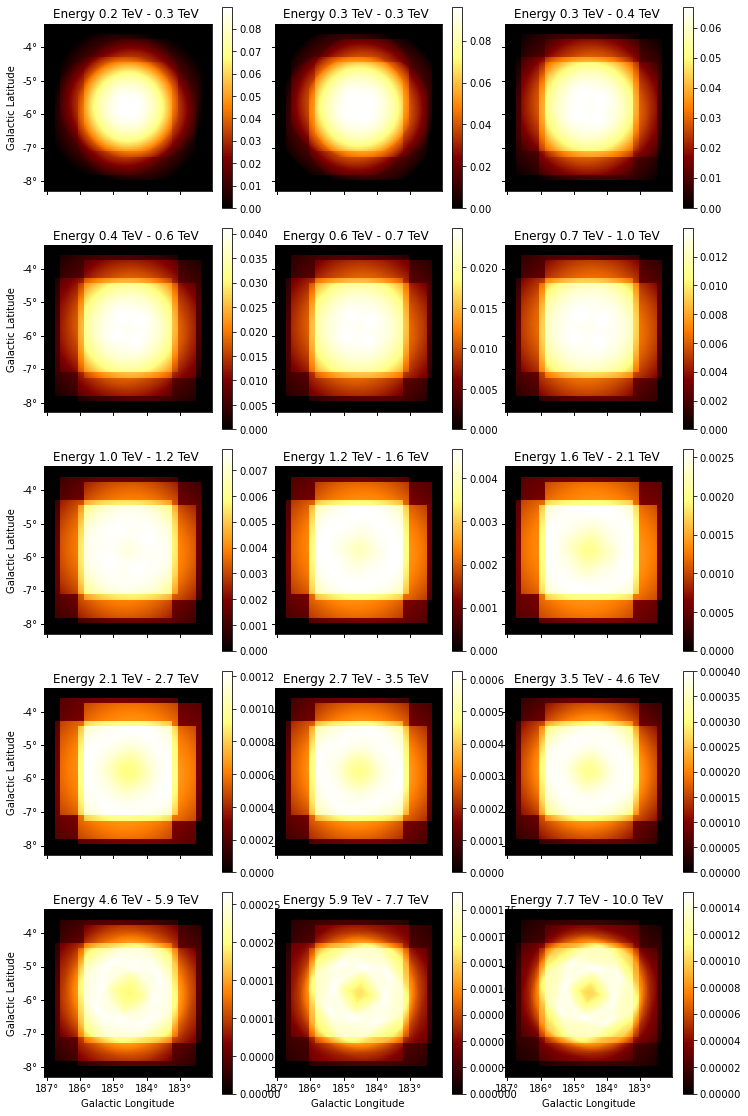

In [30]:
dataset_stacked.background.plot_grid(add_cbar=True)

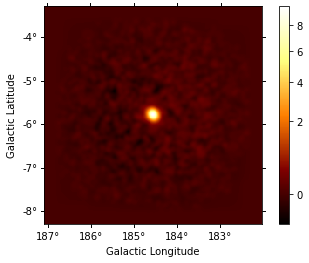

In [31]:
# Sum over axes == Sum all the energy axis together, so you get a spatial bins. Need better color...
excess = dataset_stacked.excess.sum_over_axes()
# Smooth: Basically a zoom...
excess.smooth("0.05 deg").plot(stretch="sqrt", add_cbar=True);

In [32]:
dataset_stacked.info_dict()

{'name': 'stacked',
 'counts': 8331.0,
 'background': 7261.77,
 'excess': 1069.23,
 'sqrt_ts': 12.257022466253225,
 'npred': 7261.770684016881,
 'npred_background': 7261.77,
 'npred_signal': nan,
 'exposure_min': <Quantity 12.333865 m2 s>,
 'exposure_max': <Quantity 6.1271686e+08 m2 s>,
 'livetime': <Quantity nan s>,
 'ontime': <Quantity 4807.31232393 s>,
 'counts_rate': <Quantity nan 1 / s>,
 'background_rate': <Quantity nan 1 / s>,
 'excess_rate': <Quantity nan 1 / s>,
 'n_bins': 937500,
 'n_fit_bins': 693435,
 'stat_type': 'cash',
 'stat_sum': nan}

In [33]:
coords = dataset_stacked.counts.geom.get_coord()
mask_energy = coords["energy"] > 0.18 * u.TeV
dataset_stacked.mask_fit = Map.from_geom(
    geom=dataset_stacked.counts.geom, data=mask_energy
)

In [34]:
dataset_stacked

In [35]:
target_position = SkyCoord(ra=83.6333, dec=22.0145, unit="deg", frame="icrs")

In [36]:
point_model = PointSpatialModel(lon_0="83.6333 deg", lat_0="22.0145 deg")#, evaluation_radius= "0.05 deg")
#point_model.parameters.free_parameters.freeze_all()
point_model.lat_0.frozen = True
point_model.lon_0.frozen = True
#point_model.lon_0.scale = 1.2

gaussian_model = GaussianSpatialModel(lon_0="83.6333 deg", lat_0="22.0145 deg", sigma="0.07 deg",frame="icrs")
#gaussian_model.parameters.free_parameters.freeze_all()
gaussian_model.sigma.min = 0.1

# disk model
disk_model = DiskSpatialModel(lon_0="83.6333 deg", lat_0="22.0145 deg", r_0="0.08 deg", e= 0.0, phi="0 deg",frame="icrs")
disk_model.r_0.frozen = True
disk_model.r_0.min = 0.05
disk_model.r_0.max = 0.35
#disk_model.lat_0.frozen = False

#### select model
spatial_model = point_model

In [37]:
spectral_model = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'), reference=1 * u.TeV)
#spectral_model = create_crab_spectral_model('hess_pl')
model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
    name='crab'
)

bkg_model = FoVBackgroundModel(dataset_name="stacked")    ##### https://docs.gammapy.org/dev/makers/fov.html
bkg_model.spectral_model.norm.value = 1
models_stacked = Models([model, bkg_model])
dataset_stacked.models = models_stacked

In [38]:
spatial_model.parameters.free_parameters.names

[]

In [39]:
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 8331 
  Total background counts         : 7261.77
  Total excess counts             : 1069.23

  Predicted counts                : 8154.53
  Predicted background counts     : 7261.77
  Predicted excess counts         : 892.76

  Exposure min                    : 1.23e+01 m2 s
  Exposure max                    : 6.13e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 693435 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 66263.27

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      index          

In [40]:
%%time
fit = Fit([dataset_stacked])
result = fit.run()
#result = fit.run(backend="sherpa")
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 78
	total stat : 66114.74

CPU times: user 2.25 s, sys: 281 ms, total: 2.53 s
Wall time: 2.63 s


In [41]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.8159e+00,,nan,nan,False,5.079e-02
amplitude,3.9016e-11,cm-2 s-1 TeV-1,nan,nan,False,2.099e-12
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,8.3633e+01,deg,nan,nan,True,0.000e+00
lat_0,2.2015e+01,deg,-9.000e+01,9.000e+01,True,0.000e+00
norm,9.6514e-01,,nan,nan,False,1.183e-02
tilt,0.0000e+00,,nan,nan,True,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [42]:
spatial_model.evaluation_radius

<Quantity 0. deg>

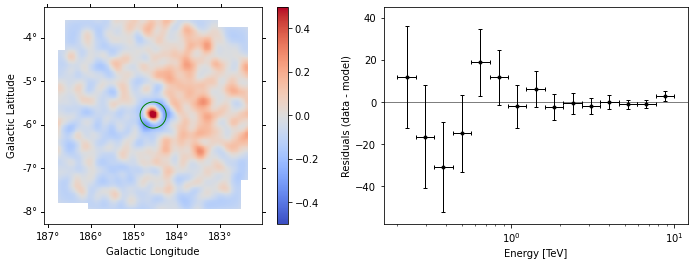

In [43]:
target_position = SkyCoord(ra=83.6333, dec=22.0145, unit="deg", frame="icrs")

region = CircleSkyRegion(target_position, radius=0.3 * u.deg)

plot_res =dataset_stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

###
#        “diff” (default): data - model
#        “diff/model”: (data - model) / model
#        “diff/sqrt(model)”: (data - model) / sqrt(model)



In [44]:
# verify fit postion is in agreement
spatial_model.position, target_position

(<SkyCoord (ICRS): (ra, dec) in deg
     (83.6333, 22.0145)>, <SkyCoord (ICRS): (ra, dec) in deg
     (83.6333, 22.0145)>)

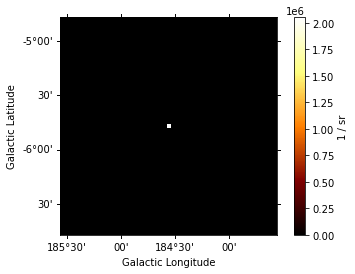

In [45]:
# model plot
model_s = spatial_model
geom = WcsGeom.create(
    skydir=model.position, frame="galactic", width=(2, 2), binsz=0.02
)
ax = model_s.plot(geom=geom, add_cbar=True)



In [46]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.2, 1.0, 10] * u.TeV,
    apply_mask_fit=True
)
result = estimator.run(dataset_stacked)
print(result)

{'counts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (250, 250, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'background': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (250, 250, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'excess': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (250, 250, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'ts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (250, 250, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'sqrt_ts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (250, 250, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'err': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (250, 250, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'flux': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (250, 250, 2)
	ndim  : 3
	unit  : 1 / (cm2 s)
	dtype : float64
}


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


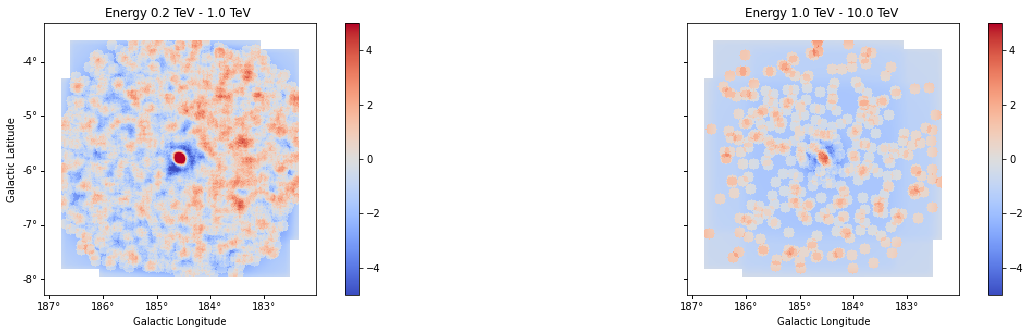

In [47]:
#counts : correlated counts map
#background : correlated background map
#excess : correlated excess map
#ts : TS map
#sqrt_ts : sqrt(delta TS), or Li-Ma significance map
#err : symmetric error map (from covariance)
#flux : flux map. An exposure map must be present in the dataset to compute flux map
#errn : negative error map
#errp : positive error map
#ul : upper limit map

result["sqrt_ts"].plot_grid(
    figsize=(22, 5), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
);

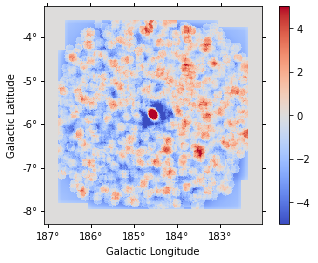

In [48]:
result_d = result["sqrt_ts"].reduce(axis_name="energy")
result_d.plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5
);

In [49]:
a=[]
for i in range(0,250):
    a.append(result_d.interp_by_pix(pix=(125,i), fill_value=None))
b=[]
for i in range(0,250):
    b.append(result_d.interp_by_pix(pix=(i,125), fill_value=None))
#result_d.plot(slice={"lon_0":[83.5,83.7]})

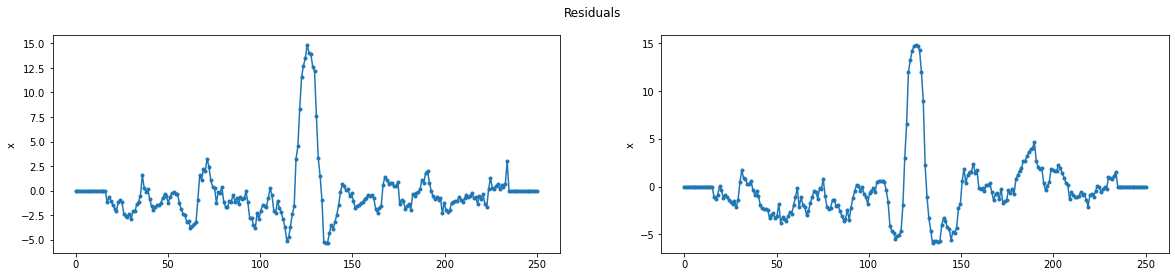

In [50]:
x1 = np.linspace(0.0, 250,250)

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Residuals')
fig.set_figwidth(20)
ax1.plot(x1, a, 'o-',markersize=3)
ax1.set_ylabel('x')
ax2.plot(x1, b, 'o-',markersize=3)
ax2.set_ylabel('x')
plt.show()

In [51]:
e_edges = MapAxis.from_energy_bounds("0.200 TeV", "12.589 TeV", nbin=15).edges

fpe = FluxPointsEstimator(energy_edges=e_edges)
flux_points = fpe.run(datasets=[dataset_stacked])

flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset_stacked.models)
plt.figure(figsize=(8, 6))

Dataset stacked does not contribute in the energy range


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

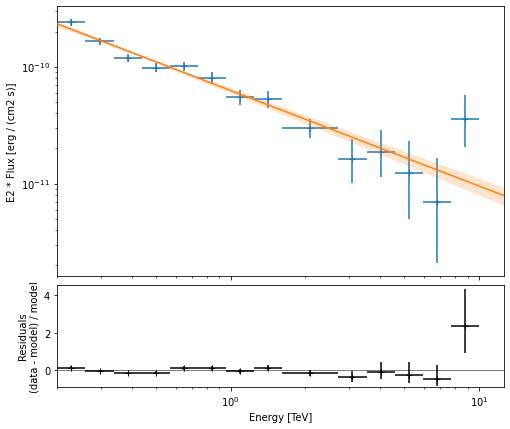

In [52]:
flux_points_dataset.plot_fit();

In [53]:
flux_points.table_formatted

counts [1],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2347,0.228,0.200,0.260,2.512e-09,1.507e-10,3.408e-11,1.304e-10,1.153,16220.606,True,0.077,705.316,0.079,0.076,1.313,0.200 .. 5.000,16538.503 .. 17183.295,26.558,2.896e-09,3.298e-09,1.938e-10,1.974e-10,1.903e-10
2376,0.296,0.260,0.337,1.205e-09,9.383e-11,2.755e-11,1.054e-10,0.979,16719.549,True,0.068,649.611,0.069,0.067,1.121,0.200 .. 5.000,16980.923 .. 17909.743,25.487,1.180e-09,1.351e-09,8.188e-11,8.348e-11,8.035e-11
1354,0.384,0.337,0.437,5.783e-10,5.844e-11,2.227e-11,8.521e-11,0.863,10851.508,True,0.068,534.720,0.070,0.067,1.006,0.200 .. 5.000,11036.307 .. 11948.739,23.124,4.989e-10,5.815e-10,3.950e-11,4.040e-11,3.861e-11
826,0.498,0.437,0.568,2.774e-10,3.639e-11,1.800e-11,6.888e-11,0.888,7355.681,True,0.079,471.836,0.081,0.077,1.054,0.200 .. 5.000,7510.193 .. 8167.675,21.722,2.463e-10,2.925e-10,2.195e-11,2.253e-11,2.138e-11
580,0.647,0.568,0.737,1.331e-10,2.266e-11,1.455e-11,5.568e-11,1.132,5314.996,True,0.102,556.921,0.105,0.099,1.346,0.200 .. 5.000,5512.875 .. 5824.890,23.599,1.506e-10,1.792e-10,1.354e-11,1.391e-11,1.317e-11
354,0.839,0.737,0.956,6.387e-11,1.411e-11,1.176e-11,4.501e-11,1.113,3552.134,True,0.122,378.812,0.126,0.118,1.374,0.200 .. 5.000,3681.628 .. 3907.191,19.463,7.110e-11,8.777e-11,7.808e-12,8.070e-12,7.550e-12
223,1.090,0.956,1.241,3.064e-11,8.789e-12,9.506e-12,3.638e-11,0.945,2487.227,True,0.138,227.357,0.145,0.132,1.247,0.200 .. 5.000,2551.569 .. 2751.007,15.078,2.896e-11,3.821e-11,4.237e-12,4.428e-12,4.048e-12
120,1.414,1.241,1.611,1.470e-11,5.474e-12,7.684e-12,2.941e-11,1.120,1412.766,True,0.184,206.157,0.193,0.174,1.525,0.200 .. 5.000,1473.634 .. 1566.298,14.358,1.646e-11,2.243e-11,2.700e-12,2.840e-12,2.563e-12


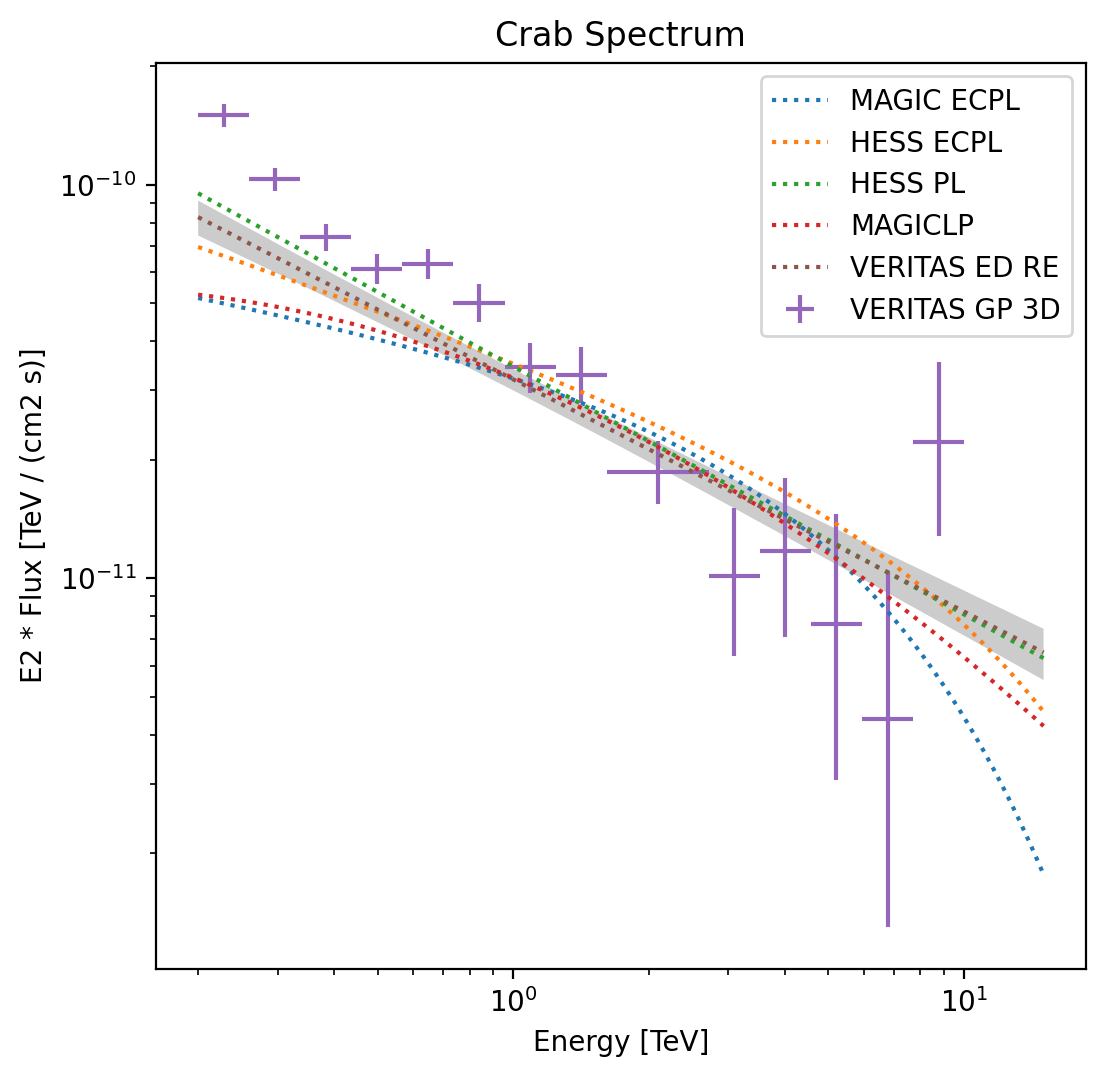

In [54]:
fig = plt.figure(figsize=(6, 6),dpi=200)

plot_kwargs = {
    "energy_range": [0.2, 15] * u.TeV,
    "energy_power": 2,
    "flux_unit": "TeV-1 cm-2 s-1",
    'ls':'dotted',
}
create_crab_spectral_model("magic_ecpl").plot(
    **plot_kwargs, label="MAGIC ECPL"
)
create_crab_spectral_model("hess_ecpl").plot(
    **plot_kwargs, label="HESS ECPL"
)
create_crab_spectral_model("hess_pl").plot(
    **plot_kwargs, label="HESS PL"
)
create_crab_spectral_model("magic_lp").plot(
    **plot_kwargs, label="MAGICLP"
)
ax = flux_points.plot(
    energy_power=2., flux_unit="TeV-1 cm-2 s-1",
    label='VERITAS GP 3D'
)
#ax.errorbar(
#        x     = ED['<E>'],
#        xerr  = ED['<E>']-ED["E_min"],
#        y     = ED['dN/dE']*ED['<E>']**2,
#        yerr  = ED["Err"]*ED['<E>']**2,
#        label = "ED",
#        ls    = '',
#        marker= 'o',
#        color = 'C3',
#        ms='2',
#    )
pwl = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'))
pwl.amplitude.error = 0.2e-11
pwl.index.error = 0.05
pwl.plot_error(**plot_kwargs)
###
# power law fit for gammapy result
#pwl_gammapy = PowerLawSpectralModel(index=2.7, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'))

pwl.plot(**plot_kwargs, label="VERITAS ED RE")
#pwl_gammapy.plot(**plot_kwargs, label="gammapy")
plt.title('Crab Spectrum')
plt.legend()

In [55]:
obs_id = list(obs_table["OBS_ID"])
events = EventList.read(f"/Users/cedrickperron/GAMMAPY/{source}/{obs_id[0]}.anasum.fits")

time_mjd=[]
for i, t in enumerate(list(events.table["TIME"].copy())):
        t /= (60*24*60)
        t += events.time_ref.mjd
        #events.table["TIME"][i]= t +87393550
        time_mjd.append(t)
        
        
        
        
events.table.add_column(time_mjd, name="TIME_MJD")


        #events.table["TIME"][i]= t
        #event.table["TIME"][i]= t-9500
print("START TIME OF THE OBSERVATION:", events.observation_time_start)
print("END TIME OF THE OBSERVATION:", events.observation_time_stop)
events.table

START TIME OF THE OBSERVATION: 56213.452871630936
END TIME OF THE OBSERVATION: 56213.466781377814


EVENT_ID,TIME,RA,DEC,ENERGY,TIME_MJD
,s,deg,deg,TeV,
int64,float64,float32,float32,float32,float64
83,242948659.37649944,82.79034,22.5814,0.19719478,56213.9057798206
85,242948659.37870017,83.79195,21.350939,0.2875948,56213.90577984606
157,242948659.54555145,83.96554,22.015257,0.20150888,56213.90578177722
167,242948659.57070807,83.25584,23.347002,0.31751126,56213.90578206838
359,242948660.01857695,83.11897,21.753605,0.18273427,56213.90578725205
452,242948660.21693096,82.18365,23.39032,0.31294948,56213.90578954781
631,242948660.56471246,83.46432,21.656263,0.20329505,56213.90579357306
802,242948660.92304355,82.81439,22.834238,0.21414417,56213.905797720414


In [56]:
%%time
# IF YOU WANT TO DO A LC ANALYSIS OR WHATEVER, USE THE JOINT


# Read the yaml file from disk
config_joint = AnalysisConfig.read(path=f"/Users/cedrickperron/GAMMAPY/{source}/"+ "config_joint.yaml")
analysis_joint = Analysis(config_joint)

# select observations:
analysis_joint.get_observations()

# run data reduction
analysis_joint.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 4
Creating geometry.
Creating datasets.
Processing observation 64080
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64081
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64082
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, meth

CPU times: user 6.1 s, sys: 1.06 s, total: 7.16 s
Wall time: 9.79 s


In [57]:
for i, dataset in enumerate(analysis_joint.datasets):
    new_dataset = dataset.copy(name=f"{observations[i].obs_id}")
    analysis_joint.datasets[i] = new_dataset

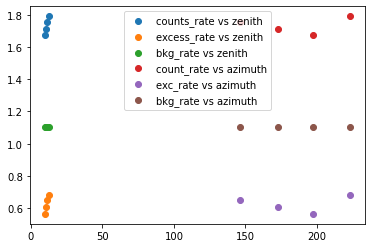

In [58]:
a = analysis_joint.datasets.info_table()
zen_col = obs_table["ZEN_PNT"]
azi_col = obs_table["AZ_PNT"]
from astropy.table import hstack
a = hstack([a, zen_col, azi_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)


a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

plt.scatter(a["ZEN_PNT"], a["counts_rate"], label= "counts_rate vs zenith")
plt.scatter(a["ZEN_PNT"], a["excess_rate"], label= "excess_rate vs zenith")
plt.scatter(a["ZEN_PNT"], a["background_rate"], label= "bkg_rate vs zenith")
plt.scatter(a["AZ_PNT"], a["counts_rate"], label= "count_rate vs azimuth")
plt.scatter(a["AZ_PNT"], a["excess_rate"], label= "exc_rate vs azimuth")
plt.scatter(a["AZ_PNT"], a["background_rate"], label= "bkg_rate vs azimuth")  
plt.legend()

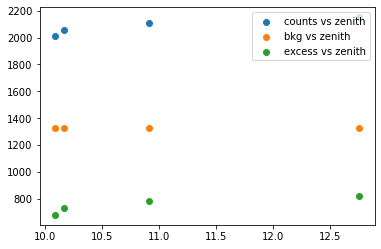

In [59]:
plt.scatter(a["ZEN_PNT"],a["counts"], label="counts vs zenith")
plt.scatter(a["ZEN_PNT"],a["background"], label="bkg vs zenith")
plt.scatter(a["ZEN_PNT"],a["excess"], label="excess vs zenith")
plt.legend()

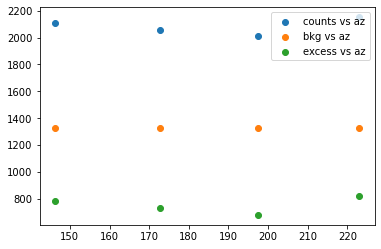

In [60]:
plt.scatter(a["AZ_PNT"],a["counts"], label="counts vs az")
plt.scatter(a["AZ_PNT"],a["background"], label="bkg vs az")
plt.scatter(a["AZ_PNT"],a["excess"], label="excess vs az")
plt.legend()

In [61]:
models_joint = Models()

model_joint = model.copy(name="crab")
models_joint.append(model_joint)

for dataset in analysis_joint.datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    models_joint.append(bkg_model)

print(models_joint)

Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.816              
    amplitude               :   3.90e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.015  deg         

Component 1: FoVBackgroundModel

  Name                      : 64080-bkg
  Datasets names            : ['64080']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoVBackgroundModel

  Name                      : 64081-bkg
  Datasets names            : ['64081']
  Spectral model type       : Powe

In [62]:
analysis_joint.datasets.models = models_joint

In [63]:
%%time
fit_joint = Fit(analysis_joint.datasets)
result_joint = fit_joint.run()
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 163
	total stat : 85903.95

CPU times: user 9.82 s, sys: 819 ms, total: 10.6 s
Wall time: 11.5 s


In [64]:
print(models_joint)

Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.817              
    amplitude               :   3.89e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.015  deg         

Component 1: FoVBackgroundModel

  Name                      : 64080-bkg
  Datasets names            : ['64080']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.337              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoVBackgroundModel

  Name                      : 64081-bkg
  Datasets names            : ['64081']
  Spectral model type       : Powe

In [65]:
stacked = MapDataset.from_geoms(**dataset_stacked.geoms)

# SAME AS THE ONE WE WROTE ON THE CONFIG
maker_safe_mask = SafeMaskMaker(methods=["offset-max", "aeff-default"], offset_max = 1.75 * u.deg, bias_percent=10)


for i, dataset in enumerate(analysis_joint.datasets):
    dataset = maker_safe_mask.run(dataset, observations[i])
    #print(dataset)
    stacked.stack(dataset)

stacked.models = [model_joint]
print(stacked)

MapDataset
----------

  Name                            : DOnkN4P5 

  Total counts                    : 7756 
  Total background counts         : 6362.44
  Total excess counts             : 1393.56

  Predicted counts                : 7681.54
  Predicted background counts     : 6362.44
  Predicted excess counts         : 1319.10

  Exposure min                    : 1.59e+05 m2 s
  Exposure max                    : 6.13e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 563955 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 60415.46

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      index        

In [66]:
print(stacked)

MapDataset
----------

  Name                            : DOnkN4P5 

  Total counts                    : 7756 
  Total background counts         : 6362.44
  Total excess counts             : 1393.56

  Predicted counts                : 7681.54
  Predicted background counts     : 6362.44
  Predicted excess counts         : 1319.10

  Exposure min                    : 1.59e+05 m2 s
  Exposure max                    : 6.13e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 563955 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 60415.46

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      index        

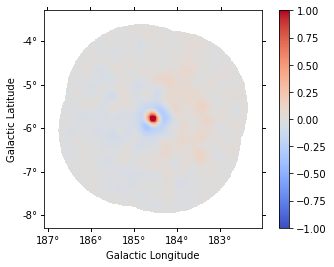

In [67]:
stacked.plot_residuals_spatial(vmin=-1, vmax=1);

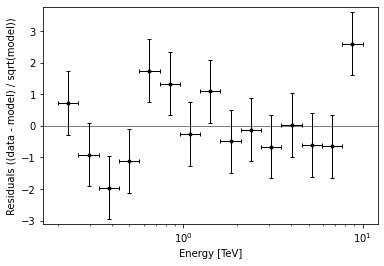

In [68]:
stacked.plot_residuals_spectral(region=region, method='diff/sqrt(model)')

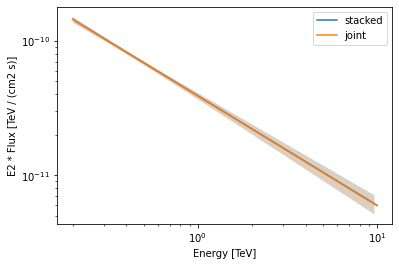

In [69]:
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
    energy_range = [0.2, 10] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)
plot_spectrum(model, result, label="stacked", color="tab:blue")
plot_spectrum(model_joint, result_joint, label="joint", color="tab:orange")
plt.legend()

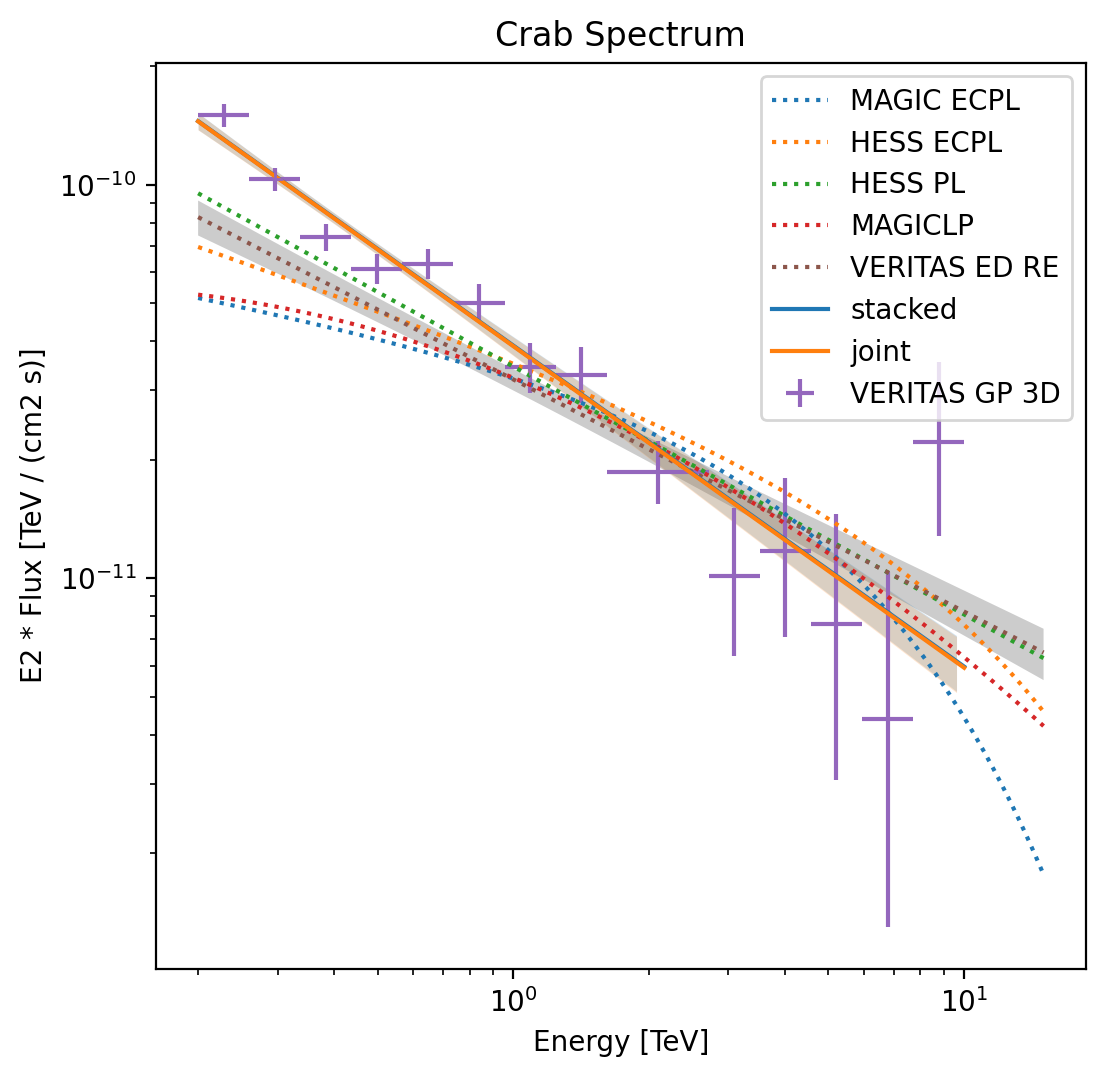

In [70]:
fig = plt.figure(figsize=(6, 6),dpi=200)

plot_kwargs = {
    "energy_range": [0.2, 15] * u.TeV,
    "energy_power": 2,
    "flux_unit": "TeV-1 cm-2 s-1",
    'ls':'dotted',
}
create_crab_spectral_model("magic_ecpl").plot(
    **plot_kwargs, label="MAGIC ECPL"
)
create_crab_spectral_model("hess_ecpl").plot(
    **plot_kwargs, label="HESS ECPL"
)
create_crab_spectral_model("hess_pl").plot(
    **plot_kwargs, label="HESS PL"
)
create_crab_spectral_model("magic_lp").plot(
    **plot_kwargs, label="MAGICLP"
)

ax = flux_points.plot(
    energy_power=2., flux_unit="TeV-1 cm-2 s-1",
    label='VERITAS GP 3D'
)
pwl = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'))
pwl.plot(**plot_kwargs, label="VERITAS ED RE")
pwl.amplitude.error = 0.2e-11
pwl.index.error = 0.05
pwl.plot_error(**plot_kwargs)

plot_spectrum(model, result, label="stacked", color="tab:blue")
plot_spectrum(model_joint, result_joint, label="joint", color="tab:orange")

plt.title('Crab Spectrum')
plt.legend()
plt.savefig('crab_spectrum_3d.pdf',dpi=300,bb_inches='tight')

In [230]:
# REFLECTED BACKGROUND
config = AnalysisConfig()
config.observations.obs_ids=list(obs_table["OBS_ID"])
config.observations.datastore = f"/Users/cedrickperron/GAMMAPY/{source}"

config.datasets.type = "1d"
config.datasets.geom.wcs.skydir = {
    "lon": "184.56 deg",
    "lat": "-5.79 deg",
    "frame": "galactic"
}
config.datasets.geom.wcs.fov = {"width": "5 deg", "height": "5 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"
config.datasets.geom.wcs.binsize_irf = "0.25 deg"
config.datasets.geom.selection.offset_max = 1.75 * u.deg
config.datasets.safe_mask.methods = ["aeff-default"]
config.datasets.safe_mask.parameters = {"aeff_percent":10, "offset_max":"1.75 deg"}
config.datasets.geom.axes.energy.min = "0.2 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 15
config.datasets.geom.axes.energy_true.min = "0.1 TeV"
config.datasets.geom.axes.energy_true.max = "17 TeV"
config.datasets.geom.axes.energy_true.nbins = 20
config.datasets.background.exclusion = (f"/Users/cedrickperron/GAMMAPY/{source}/exclusion_mask_crab.fits")
config.datasets.background.method = "reflected"
config.datasets.background.parameters = {"max_region_number": 6, "binsz": 0.02 * u.deg}
config.datasets.stack = False

config.datasets.on_region = {"frame": "icrs", "lon": "83.62875 deg", "lat": "22.01236111 deg", "radius": "0.089 deg"}

spectrum_datasets = Analysis(config)
spectrum_datasets.get_observations()
spectrum_datasets.get_datasets()
for dataset in spectrum_datasets.datasets:
    print(dataset)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 18
Reducing spectrum datasets.
Processing observation 97312
Processing observation 97374
Processing observation 97401
Processing observation 97405
Processing observation 97407
Processing observation 97412
Processing observation 97414
Processing observation 97437
Processing observation 97440
Processing observation 97316
Processing observation 97400
Processing observation 97403
Processing observation 97406
Processing observation 97411
Processing observation 97413
Processing observation 97415
Processing observation 97438
Processing observation 97487


SpectrumDatasetOnOff
--------------------

  Name                            : bqzgKf6I 

  Total counts                    : 29 
  Total off counts                : 4.00
  Total background counts         : 0.67
  Total excess counts             : 28.33

  Predicted counts                : 4.71
  Predicted background counts     : 4.71
  Predicted excess counts         : nan

  Exposure min                    : 1.53e+02 m2 s
  Exposure max                    : 3.65e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 99.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : tzgHYiy_ 

  Total counts                    : 42 
  Total off counts    


SpectrumDatasetOnOff
--------------------

  Name                            : bPl332Dp 

  Total counts                    : 200 
  Total off counts                : 37.00
  Total background counts         : 6.17
  Total excess counts             : 193.83

  Predicted counts                : 33.86
  Predicted background counts     : 33.86
  Predicted excess counts         : nan

  Exposure min                    : 7.07e+04 m2 s
  Exposure max                    : 3.48e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 610.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : WOFMIZ9w 

  Total counts                    : 167 
  Total off co

In [101]:
target_position = SkyCoord(ra="05h34m30.9s",dec="+22d00m44.5s", frame="icrs")

maker_safe_mask = SafeMaskMaker(methods=["offset-max", "aeff-default"], offset_max = 1.75 * u.deg, bias_percent=10)

list_of_dataset = Datasets()
stacked.models = [model_joint]
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)


for i, dataset in enumerate(analysis_joint.datasets):
    dataset = dataset.to_spectrum_dataset(on_region=on_region, containment_correction=True, name=dataset.name)
    
    #dataset = maker_safe_mask.run(dataset, observations[i])
    list_of_dataset.append(dataset)
   
    print(dataset)
    
stacked_spec = stacked.to_spectrum_dataset(on_region=on_region, containment_correction=True, name=stacked.name)


SpectrumDataset
---------------

  Name                            : 64080 

  Total counts                    : 140 
  Total background counts         : 5.17
  Total excess counts             : 134.83

  Predicted counts                : 5.17
  Predicted background counts     : 5.17
  Predicted excess counts         : nan

  Exposure min                    : 2.24e+05 m2 s
  Exposure max                    : 2.26e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDataset
---------------

  Name                            : 64081 

  Total counts                    : 163 
  Total background counts         : 5.00
  Total excess counts             : 158.00

  Predicted counts                : 5.00
  Predicted background counts     : 5.00
  Predic

In [102]:
print(len(list_of_dataset))
"""
models_spectrum = Models()

model_spectrum = model.copy()
models_spectrum.append(model_joint)

for dataset in list_of_datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    models_joint.append(bkg_model)

print(models_spectrum)
"""

4


'\nmodels_spectrum = Models()\n\nmodel_spectrum = model.copy()\nmodels_spectrum.append(model_joint)\n\nfor dataset in list_of_datasets:\n    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)\n    models_joint.append(bkg_model)\n\nprint(models_spectrum)\n'

In [103]:
Datasets(stacked_spec).info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str8,float32,float32,float32,float64,float64,float32,float64,float32,float32,float64,float64,float64,float64,float64,int64,int64,str4,float64
DOnkN4P5,595.0,20.384132,574.61584,53.53125628172347,20.384133291896433,20.384132,nan,944070.4,921684900.0,4807.312323927879,4807.312323927879,0.12376978234562618,0.004240234669961858,0.11952954291454583,15,15,cash,nan


In [104]:
list_of_dataset.info_table(cumulative=True)

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
64080,140.0,5.171553278914057,134.82844672108595,25.571750683574795,5.171553278914057,5.171553278914057,nan,223559.01089522953,225760462.24290583,1201.8021302819252,1201.8021302819252,0.11649172228306671,0.004303165345280995,0.11218855693778573,15,15,cash,nan
64080,303.0,10.16660221524865,292.83339778475136,38.359818762466084,10.16660221524865,10.16660221524865,nan,473986.3874904661,460121955.23431325,2403.686617165804,2403.686617165804,0.12605636601549516,0.004229587227654547,0.12182677878784062,15,15,cash,nan
64080,447.0,15.148867475396248,431.85113252460377,46.499027861294685,15.148867475396248,15.148867475396248,nan,728423.8583612144,694585773.7297436,3605.5122197270393,3605.5122197270393,0.12397683678737907,0.004201585392641691,0.1197752513947374,15,15,cash,nan
64080,595.0,20.38413345450317,574.6158665454968,53.53125571866058,20.38413345450317,20.38413345450317,nan,948631.6758950643,919090677.4982324,4807.312323898077,4807.312323898077,0.12376978234639348,0.004240234892409571,0.1195295474539839,15,15,cash,nan


In [356]:
"""%%time
fit_ = Fit(list_of_datasets)
result_spectrum = fit_.run()
print(result_spectrum)
print(models_spectrum)"""

'%%time\nfit_ = Fit(list_of_datasets)\nresult_spectrum = fit_.run()\nprint(result_spectrum)\nprint(models_spectrum)'

In [357]:
%%time
# Defining the energy edges
energy_edges = MapAxis.from_energy_bounds("0.200 TeV", "12.589 TeV", nbin=15).edges
print(energy_edges)

# There are other parameters to FluxPointsEstimator, but I don't think that they matter a lot
fpe = FluxPointsEstimator(energy_edges=energy_edges)

flux_points_joint = fpe.run(datasets=list_of_datasets)

[ 0.2         0.26360931  0.34744934  0.45795441  0.60360523  0.79557979
  1.0486112   1.38211837  1.82169635  2.4010806   3.164736    4.17126937
  5.49792721  7.246524    9.55125597 12.589     ] TeV


IndexError: list index out of range

In [358]:
flux_points_joint.table

counts [18],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0 .. 0,0.22785697589078346,0.2,0.2595940073104654,4.739200005920804e-10,2.8298924053638315e-11,6.418801349759261e-12,2.4605358419655258e-11,1.3858807599026477,-265.35470652277604,True,0.1618812087128673,765.0953467858477,0.16823013764484834,0.15567685889272725,1.7353386661734622,0.20000000000000004 .. 5.000000000000001,-109.00111316471472 .. -70.66429593253054,27.660356953333913,6.567966105536157e-10,8.224117017003873e-10,7.671874252904876e-11,7.97276269322523e-11,7.377837705861453e-11
2 .. 0,0.29575152732566284,0.2595940073104654,0.3369452431575296,2.5982993768334226e-10,2.0138111558146496e-11,5.9288084734863665e-12,2.2727055963040958e-11,1.2736316659138538,-718.0785571928993,True,0.1027487122084204,1276.7978098465874,0.10550373993238467,0.10003249858347418,1.4902284228800837,0.20000000000000004 .. 5.000000000000001,-415.58995177299073 .. -236.20503494728302,35.73230764793379,3.30927636385928e-10,3.872059582508776e-10,2.669719149015754e-11,2.7413030171991057e-11,2.599143787325312e-11
3 .. 0,0.3838766207332969,0.3369452431575296,0.4373448295773113,1.4245357113476032e-10,1.4330705166022547e-11,5.4762202473522934e-12,2.0992137726170644e-11,1.017756927976734,-729.8679496977771,True,0.07868603394177823,1014.0160616524406,0.08068147939418868,0.07676031627922535,1.1834184726268637,0.20000000000000004 .. 5.000000000000001,-469.01140755438314 .. 65.59410409482702,31.84361885295766,1.449831089374288e-10,1.6858218757254033e-10,1.120910653343727e-11,1.1493364864137757e-11,1.0934781175409328e-11
5 .. 6,0.49826035144478104,0.4373448295773113,0.5676604844324338,7.810116151348789e-11,1.0198032221764456e-11,5.058181307698152e-12,1.938965816915046e-11,0.9791162342298776,-760.1891397384753,True,0.07043816686044711,925.0033696759265,0.0720664536349108,0.06888192617531388,1.1268870506809419,0.20000000000000004 .. 5.000000000000001,-481.29160219571077 .. 235.91401452021665,30.413868048571633,7.64701151500657e-11,8.801118755269025e-11,5.5013026466817895e-12,5.628473735044454e-12,5.379758441578339e-12
4 .. 15,0.6467270065773575,0.5676604844324338,0.7368062997280773,4.281950519854326e-11,7.25713494146296e-12,4.6720542611333414e-12,1.7909507303193795e-11,1.011282533960184,-914.6773536496912,True,0.06726354518077839,1101.5666364862318,0.06870076284840851,0.06585666185885546,1.1516940132740268,0.20000000000000004 .. 5.000000000000001,-574.2402223144276 .. 179.87210282882495,33.18985743395461,4.3302617720104105e-11,4.9314967788518346e-11,2.88019172254079e-12,2.941732671931316e-12,2.819949674823967e-12
5 .. 14,0.8394322763665893,0.7368062997280773,0.9563524997900371,2.3476091647259706e-11,5.16433037407e-12,4.315403045310699e-12,1.6542346907047375e-11,0.7949984987208154,-529.421063017727,True,0.06037310991996764,849.6405154191671,0.0618337055619564,0.058931260326846174,0.9216296997824227,0.20000000000000004 .. 5.000000000000001,-325.0798702210662 .. 713.364819858678,29.14859371254756,1.866345761540374e-11,2.1636263296928604e-11,1.4173246615112444e-12,1.4516137386621607e-12,1.3834756683215608e-12
4 .. 10,1.089557942438745,0.9563524997900371,1.2413168891093835,1.2870930583506273e-11,3.6750464787644535e-12,3.985977559892331e-12,1.5279551612472327e-11,0.8272372624196578,-445.0414009814811,True,0.06590424793335563,877.0602774327856,0.06760724545942894,0.06422423866800424,0.9659065812626771,0.20000000000000004 .. 5.000000000000001,-246.81996312312185 .. 602.5978264589944,29.61520348457504,1.0647313380693178e-11,1.24321

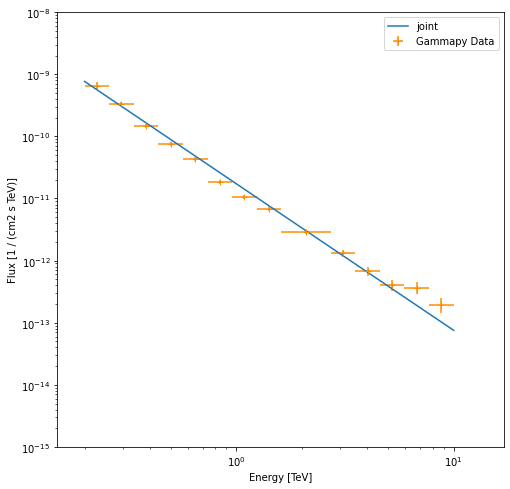

In [359]:
plt.figure(figsize=(8,8))
# Final Plot with the best-fit model, the flux points and residuals


ax_spectrum = flux_points_joint.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange", label="Gammapy Data")

"""
# Below is the same thing as above, but with the dataset, you've got a bigger range of plot. Like the residuals plot next run box
flux_points_joint_dataset= FluxPointsDataset(data=flux_points_joint,models=joint_model)
ax_spectrum = flux_points_joint_dataset.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1");
"""

# The reason we re-code this function is because we adjust the energy_range
def plot_spectrum(model, result, label, color, ax=None):
    spec = model.spectral_model
    energy_range =[0.2, 10]*u.TeV
    spec.plot(ax=ax, energy_range=energy_range, energy_power=0, label=label, color=color)
    spec.plot_error(ax=ax, energy_range=energy_range, energy_power=0, color=color)
plot_spectrum(ax=ax_spectrum,model=model , result=result_joint, label="joint", color="tab:blue")

# For the ED DATA
#ax_spectrum.errorbar(spectrum["E"], spectrum["dNdE"], yerr=spectrum["dNdE_erru"], fmt="o",label="EventDisplay")

# LIMITS OF THE GRAPH
# # DEFINIE THE AXIS BOUNDARY WITH ax (not plt)
ax_spectrum.set_xlim([0.15, 17])
ax_spectrum.set_ylim([1e-15, 1e-8])

plt.legend()

In [361]:
obs_id_0_90_az =[]
obs_id_90_180_az = []
obs_id_180_270_az = []
obs_id_270_360_az = []

for i, az in enumerate(list(obs_table["AZ_PNT"])):
    if (az >= 0) and (az < 90):
        obs_id_0_90_az.append(list(obs_table["OBS_ID"])[i])
    if (az >=90) and (az <180):
        obs_id_90_180_az.append(list(obs_table["OBS_ID"])[i])
    if (az>=180) and (zen < 270):
        obs_id_180_270_az.append(list(obs_table["OBS_ID"])[i])
    if (zen>=270) and (zen <= 360):
        obs_id_270_360_az.append(list(obs_table["OBS_ID"])[i])
"""
observations_0_90_az = data_store.get_observations(obs_id_0_90_az)
observations_90_180_az = data_store.get_observations(obs_id_90_180_az)
observations_180_270_az = data_store.get_observations(obs_id_180_270_az)
observations_270_360_az = data_store.get_observations(obs_id_270_360_az)
"""


In [ ]:

config = AnalysisConfig()
config.observations.obs_ids=
config.observations.datastore = f"/Users/cedrickperron/GAMMAPY/{source}"

In [ ]:
config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": "184.56 deg",
    "lat": "-5.79 deg",
    "frame": "galactic",
}
config.datasets.geom.wcs.fov = {"width": "5 deg", "height": "5 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"
config.datasets.geom.wcs.binsize_irf = "0.25 deg"
config.datasets.geom.selection.offset_max = 1.75 * u.deg
config.datasets.safe_mask.methods = ["aeff-default"]
config.datasets.safe_mask.parameters = {"aeff_percent":10, "offset_max":"1.75 deg"}
config.datasets.geom.axes.energy.min = "0.2 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 15
config.datasets.geom.axes.energy_true.min = "0.1 TeV"
config.datasets.geom.axes.energy_true.max = "17 TeV"
config.datasets.geom.axes.energy_true.nbins = 20
config.datasets.background.exclusion = (f"/Users/cedrickperron/GAMMAPY/{source}/exclusion_mask_crab.fits")
config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}

In [ ]:
print(config)

In [ ]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

In [ ]:
#config_joint.write(path=f"/Users/cedrickperron/GAMMAPY/{source}/" +"config_joint.yaml", overwrite=True)
#config_stack.write(path=f"/Users/cedrickperron/GAMMAPY/{source}/"+ "config_stack.yaml", overwrite=True)

config_stacked = AnalysisConfig.read(path=f"/Users/cedrickperron/GAMMAPY/{source}/"+ f"config_stack.yaml")
analysis_stacked = Analysis(config_stacked)

In [ ]:
# select observations:
analysis_stacked.get_observations()
# run data reduction
analysis_stacked.get_datasets()